<a href="https://colab.research.google.com/github/anitagold/SPAIC_Hungary/blob/master/Style/Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with Deep Neural Networks


## Concept
The Style Transfer means changing the style of one picture from another. Every picture can split into two big parts:
* content
* style

If you imagine a famous paintings, for example Sunflowers By Van Gogh, you are able two determine hese parts: content is the sunflowers, the vase and the desk or in one word: the composition. Style means the colour, the lines of paintings, textures, the unique marks of painter. This works not just paintings, but every pictures. With this Jupiter Notebook Code you will be able to create style transfered picture. For this you have to choose two pictures: one for style and one for the source of content. Don't worry, if you have no ideas, we provide some of them. Feel free to try it and change the source data and the modell as well.

## Idea
This style transfer method based in Udacity course and this paper: [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

In this paper, style transfer uses the 19-layer VGG Network. Our program is a generalized version of this. The user can upload photos for style and content image, and can choose which model to use. The user can set several parameters too.

In [0]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
from torchvision.utils import save_image

## Load in VGG19 (features)

VGG19 is splitted into two parts:
* `features`: convolutional and pooling layers
* `classifier`: the three linear and classifier layers at the end

We only need the `features` part, that we load in and "freeze" the weights.

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [31]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load Content and Style Images

In this part you are able to load the source pictures. It's ideal when the x and y dimensions of your picture are the same. However, you don't have to worry about resulution, the next function will be transform them to the right size.

This funcition transforms your pictures and converts them to normalized tensors. However, the name of funcion is load_image, the source directories and files will be set up in another part of this notebook. 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# helper function to show un-normalizied images:
# It converts pictures from Tensor images to a NumPy images for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Loading images by file name and forcing the style image to be the same size as the content image.

### Instructions
Don't forget to set up the source data properly. Be careful, the default setting of main dir works with Google Colab

In [0]:
# defining main directory, style, content and target picture
maindir = '/content/drive/My Drive/Colab Notebooks/Style'
content_file = maindir + '/images/parlament.png'
style_file = maindir + '/images/paul-signac.jpg'
target_file = maindir + '/target/parlament_paul-signac_beta1e6.jpg' 

# load in content and style image
content = load_image(content_file).to(device)

# resize style to match content
style = load_image(style_file, shape=content.shape[-2:]).to(device)

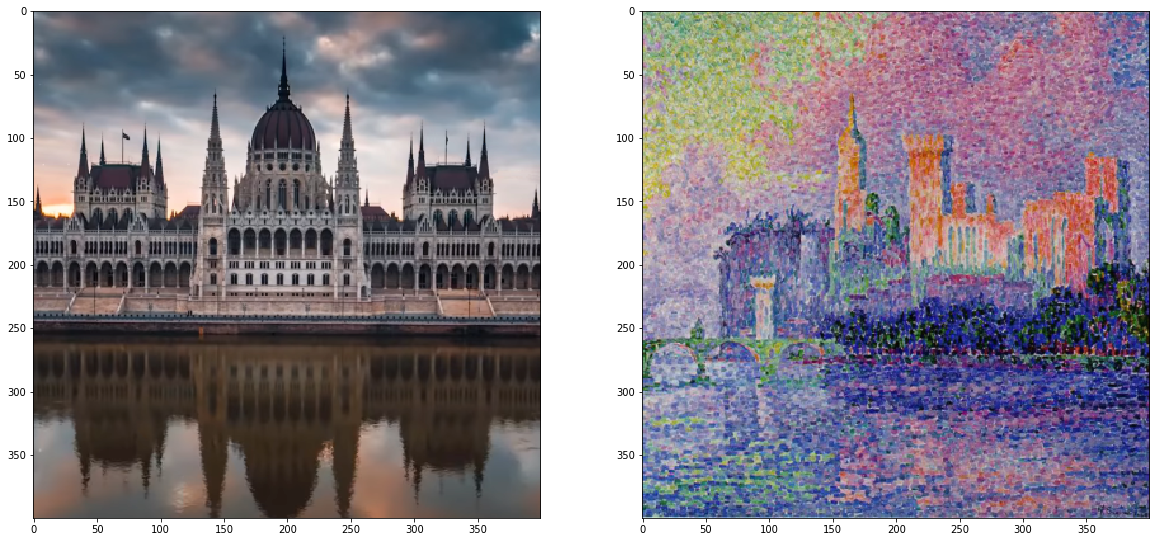

In [35]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

We have to pass forward the source image through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

If you unremarked the next 'print(vgg)' command, you will see the names of layers

In [0]:
# print out VGG19 structure so you can see the names of various layers
# print(vgg)

## Content and Style Features


In [0]:
def get_features(image, model, layers=None):
    
    # Layers
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ##  This is for content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of convolutional layers is a tensor. The dimension of this tensor are connected to the `batch_size`, a depth, `d` and some height and width (`h`, `w`). If you want to know ore about it: https://en.wikipedia.org/wiki/Gramian_matrix

In [0]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Make it all parts together

In this section we collect the contect and style features, make a style representation and create a target image. The target image is the clone of content of original picture with the style from style source. This style will be changed over each iteration.

In [0]:
# get content and style features before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create target image and pass it to device
target = content.clone().requires_grad_(True).to(device)

---
## Losses and Weights

#### Style weights of each layer

In this section you can modify the style representation of each convulutional layer. That weight range is advised to be between 0 and 1. Changing these values affect the outlook of target image and the computing time. If earlier layers get higher values, the target image get larger or more style artifacts.

#### Portionised between content and style weight

Alpha (`content_weight`) and a beta (`style_weight`) represent the ratio, that will affect how stylized the final image is. Default value  of alpha equals 1, but you are free to change it and see the result. Set the beta to get your desired ratio.

In [0]:
# weights for each style layer 
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.1,
                 'conv4_1': 0.05,
                 'conv5_1': 0.05}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## One step before ending

In this section we update the target. If the result is far away your imagination, you can stop the process and change the settings. 

We recommend to test the code over 1 or 2 epochs. For the good result you should itarate your target picutre over at least 2000 epochs. Don't forget, changing values causes different result such as playing with number of epochs. 


###  Inside the loop: Loss 

We use 3 differents losses: content, style and target or total loss. The loss value represents the gap between present state and the desirered state. The calculating method is similiar with other ML examples. The only exception is the total loss. The total loss is the sum fo content and style loss biased with ratio of alpha and beta. 

Total loss:  4599139.0


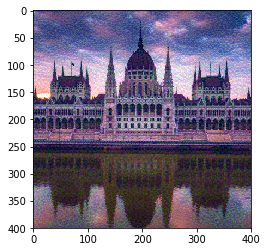

Total loss:  1882220.75


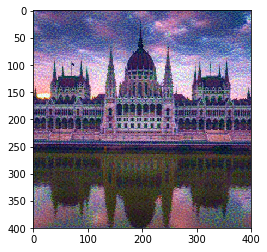

Total loss:  1159837.75


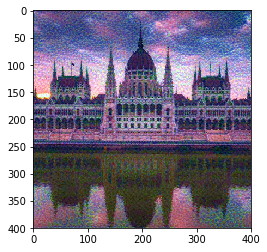

Total loss:  826408.75


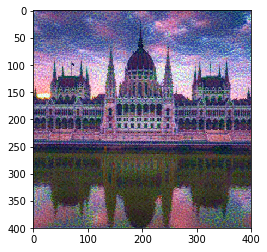

Total loss:  625904.0


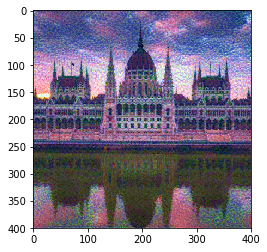

In [41]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    
    # get the features from target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display images during proecessing and print the connected loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

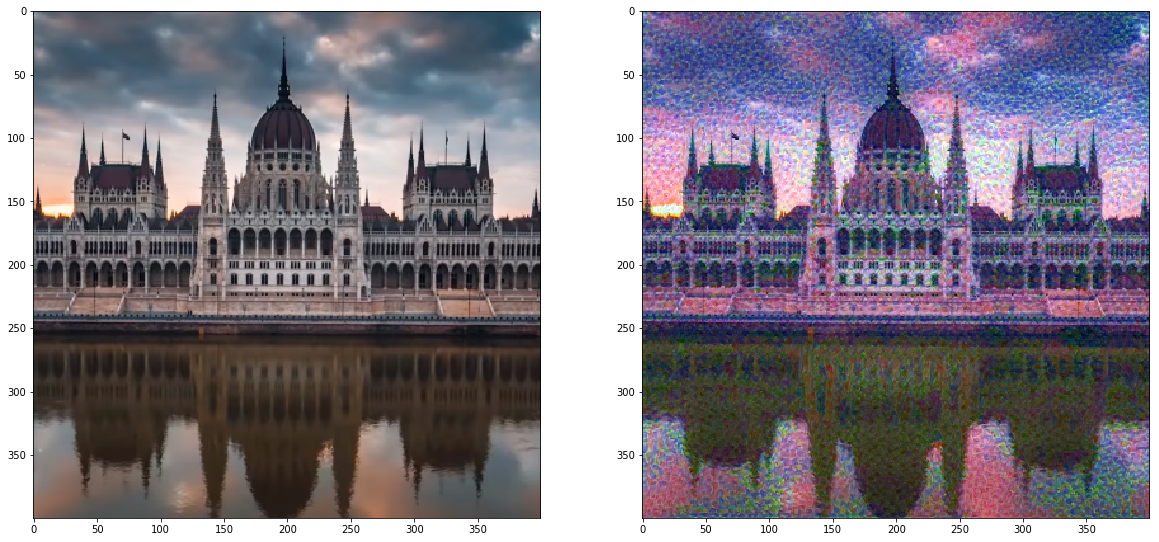

In [42]:
# display content and final stage of target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

##Save the target picture

In [0]:

save_image(target, target_file)